In [2]:
"""General methyl data import using MSM package. General dictonary data, beta value methylation array df, survival metadata df"""

import sys
sys.path.insert(0, '/Users/zacksiegfried/Documents/methylspan')
import MethylFormatting

all_files = MethylFormatting.pullMethylMetaData('pancreas')

# not gaureteed to return same number of cases, (remove file_id from sample data if missing from meta data)
# missing values dropped anyways in next steps
sample_data = MethylFormatting.methylDataFormat(all_files, 471)
meta_data = MethylFormatting.metaDataFormat(sample_data, all_files)



Number of methylation files for all cases for primary site pancreas: 471
Final number of cases in methylation dataset : 435
Final number of cases in metadata dataset : 426


In [3]:
### FORMATTING FOR SURVIVAL + PCA

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def survivalPCAFormat(sample_data, meta_data):

    # drops all CpG sites with at least 1 missing value
    sample_data.index.name = 'id'
    sample_data.dropna(axis=1, inplace=True)

    # standardizes dataframe
    scaled_df = sample_data.copy()
    scaled_df = pd.DataFrame(StandardScaler().fit_transform(scaled_df), index=scaled_df.index, columns=scaled_df.columns)

    print("Number of CpG sites with complete data from all cases: " + str(scaled_df.shape[1]))

    # converts CpG sites to PCA components
    pca = PCA(n_components=15)      # setting number of PCAs to 15 (decided using PCA notebook's scree plot)
    pca.fit(scaled_df)

    output = pca.transform(scaled_df)
    x = pd.DataFrame(output, index=scaled_df.index)

    meta_data.index.name = 'id'

    # merges dfs and formats 
    full_data = pd.merge(meta_data, x, on = 'id')
    full_data.replace(['Dead', 'Alive'],[1, 0], inplace=True)
    full_data = full_data[full_data['days_to_death'].notna()]

    print("Final number of cases used: " + str(full_data.shape[0]))

    return(full_data)


full_data = survivalPCAFormat(sample_data, meta_data)

Number of CpG sites with complete data from all cases: 272906
Final number of cases used: 400


<AxesSubplot: xlabel='timeline'>

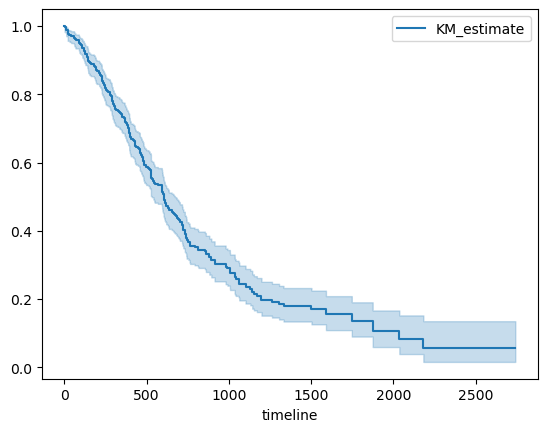

In [12]:
# General Kaplan Meier plot of data set

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(full_data['days_to_death'], event_observed=full_data['vital_status'])

kmf.plot_survival_function()



In [37]:
### SURVIVAL ANALYSIS EXECUTION & TESTING

from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

# model trained on complete data set 
cph = CoxPHFitter()
cph.fit(full_data, duration_col='days_to_death', event_col='vital_status')
print(cph.confidence_intervals_)

# Concordance index (will remodel cph.)
scores = k_fold_cross_validation(cph, full_data, 'days_to_death', event_col='vital_status', k=5, scoring_method="concordance_index")
print(scores)

           95% lower-bound  95% upper-bound
covariate                                  
0                 0.000878         0.002606
1                -0.003331        -0.000919
2                -0.005126        -0.000637
3                 0.000462         0.003119
4                -0.001718         0.000675
5                -0.008452        -0.001333
6                -0.000603         0.002508
7                -0.008406        -0.000402
8                -0.001841         0.002296
9                -0.005824        -0.000218
10               -0.002096         0.002491
11               -0.001126         0.004228
12               -0.014409        -0.004610
13               -0.002454         0.003323
14               -0.004125         0.006418
267.5


/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")


/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")
/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")
/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplot

[273.0, 289.0, 232.5, 275.5, 288.0]


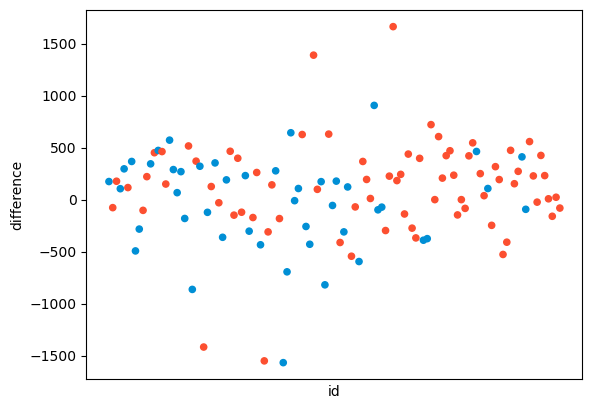

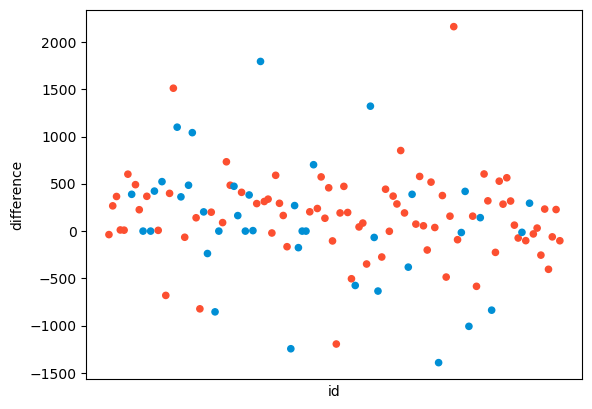

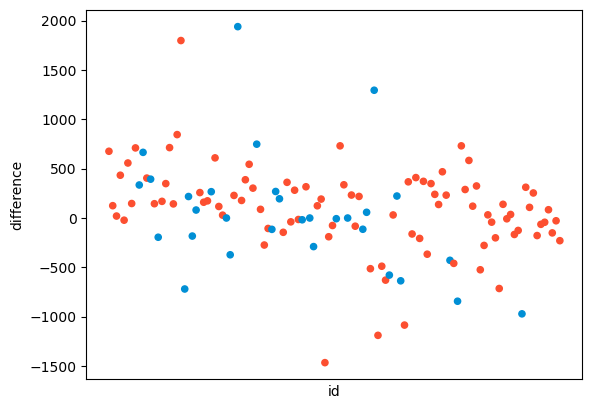

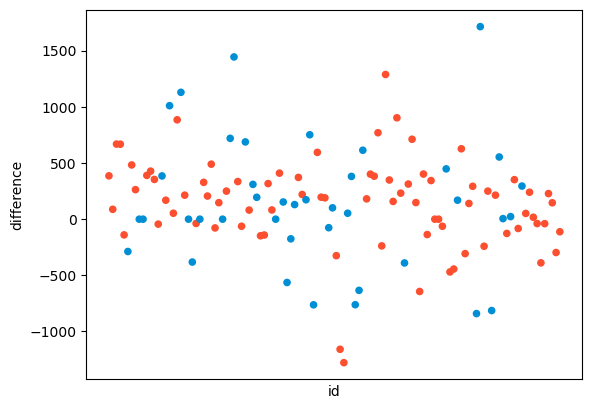

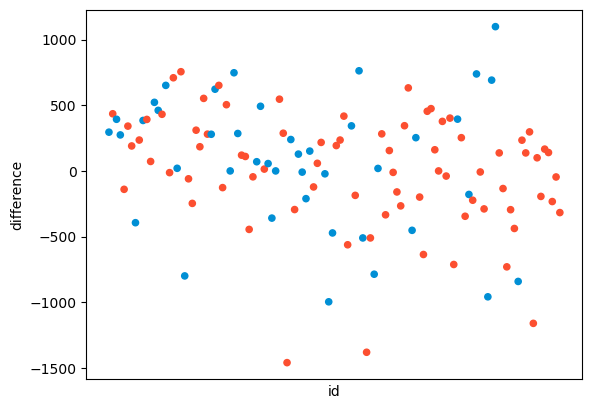

In [11]:
### TIME OF DEATH PREDICTION + CROSS VALIDATION

import pandas as pd
from lifelines import CoxPHFitter
import numpy as np

# returns a list of the median differences between predicted and actual time to event / uses train (0.7) test (0.3) split for k-fold times
def k_fold_cross_survival(k, data):
    
    scores = []
    for i in range(k):

        # splitting data set
        X_train = data.sample(frac = 0.7)
        X_test = data.drop(X_train.index)
        X_test_a = X_test.copy(deep=True)

        # fitting Cox model using X_train
        cph = CoxPHFitter()
        cph.fit(X_train, duration_col='days_to_death', event_col='vital_status')

        # predicting values using X_test, formatting
        median_table = cph.predict_median(X_test)
        median_table = median_table.to_frame()
        median_table.columns = ['pred']
        median_table.index.name = 'id'

        # merges predicted and actual values
        pred_data = pd.merge(median_table, X_test_a, on='id')
        # calculates difference between predicted and actual 
        pred_data['difference'] = pred_data['pred'] - pred_data['days_to_death']
        pred_data['difference'].replace([np.inf, -np.inf], 0, inplace=True)

        pred_data2 = pred_data.copy(deep=True)

        ### graphing could be improved (red = death, blue = alive)
        pred_data2.reset_index().plot(kind='scatter', x='id', y='difference', c=np.where(pred_data2['vital_status'], '#fc4f30', '#008fd5')).tick_params(bottom=False, labelbottom=False)

        scores.append(abs(pred_data['difference']).median())
    
    return(scores)

        
print(k_fold_cross_survival(5, full_data))

/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='days_to_death', ylabel='deviance'>

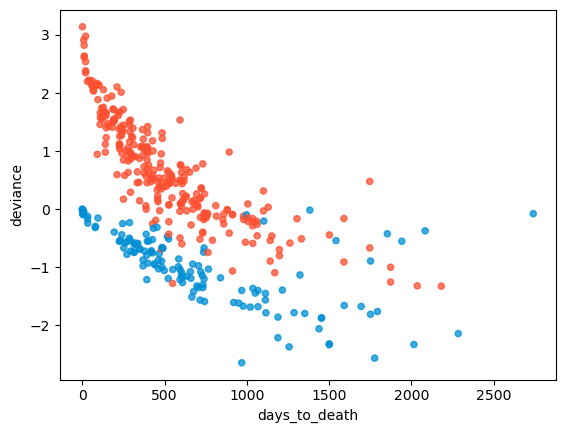

In [7]:
# Residual modeling (needs work)
import numpy as np

r = cph.compute_residuals(full_data, 'deviance')

r.plot.scatter(
    x='days_to_death', y='deviance', c=np.where(r['vital_status'], '#fc4f30', '#008fd5'),
    alpha=0.75
)
